# Hierarchical Clustering

Hierarchical clustering avoids the need to specify a target number of clusters because it assumes that data can successively be merged into increasingly dissimilar clusters. It does not pursue a global objective but decides incrementally how to produce a sequence of nested clusters that range from a single cluster to clusters consisting of the individual data points.

While hierarchical clustering does not have hyperparameters like k-Means, the measure of dissimilarity between clusters (as opposed to individual data points) has an important impact on the clustering result. The options differ as follows:

- Single-link: distance between nearest neighbors of two clusters
- Complete link: maximum distance between respective cluster members
- Group average
- Ward’s method: minimize within-cluster variance


## Imports & Settings

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap

import seaborn as sns

from IPython.display import HTML

In [2]:
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 
                                        'medium green', 
                                        'pale red']))
sns.set_style('white')

In [3]:
# if you have difficulties with ffmpeg to run the simulation, see https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available
# plt.rcParams['animation.ffmpeg_path'] = your_windows_path
plt.rcParams['animation.ffmpeg_args'] = '-report'
plt.rcParams['animation.bitrate'] = 2000

## Load Iris Data

In [4]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [5]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## Create DataFrame

In [6]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


### Standardize Data

The use of a distance metric makes hierarchical clustering sensitive to scale:

In [7]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

### Reduce Dimensionality to visualize clusters

In [8]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

C:\Users\mecha2k\AppData\Local\Temp/ipykernel_30676/1283365591.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(14, 6)).gca(title='2D Projection',


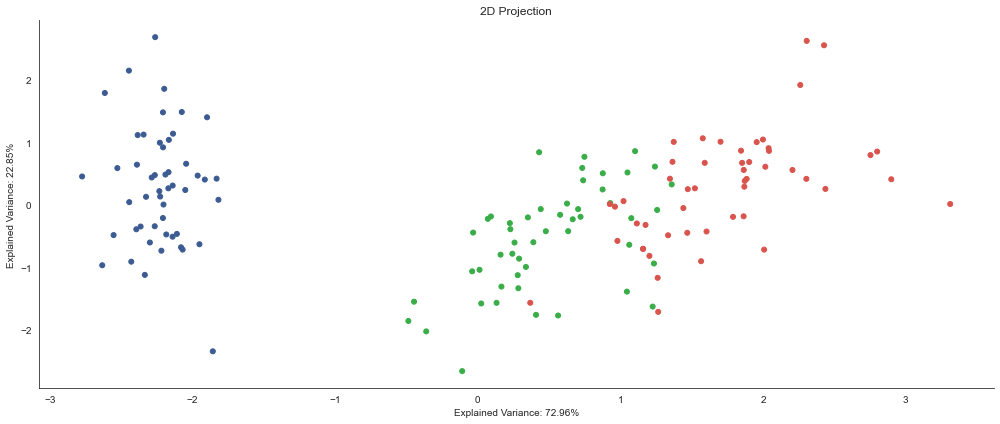

In [9]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure(figsize=(14, 6)).gca(title='2D Projection',
                                     xlabel=f'Explained Variance: {ev1:.2%}',
                                     ylabel=f'Explained Variance: {ev2:.2%}')
ax.scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
sns.despine()
plt.tight_layout()

### Perform agglomerative clustering

In [10]:
Z = linkage(features_standardized, 'ward')
Z[:5]

array([[1.01000000e+02, 1.42000000e+02, 0.00000000e+00, 2.00000000e+00],
       [7.00000000e+00, 3.90000000e+01, 1.21167870e-01, 2.00000000e+00],
       [1.00000000e+01, 4.80000000e+01, 1.21167870e-01, 2.00000000e+00],
       [9.00000000e+00, 3.40000000e+01, 1.31632184e-01, 2.00000000e+00],
       [0.00000000e+00, 1.70000000e+01, 1.31632184e-01, 2.00000000e+00]])

In [11]:
linkage_matrix = pd.DataFrame(data=Z, 
                              columns=['cluster_1', 'cluster_2', 
                                       'distance', 'n_objects'],
                              index=range(1, n))
for col in ['cluster_1', 'cluster_2', 'n_objects']:
    linkage_matrix[col] = linkage_matrix[col].astype(int)
linkage_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 1 to 149
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cluster_1  149 non-null    int32  
 1   cluster_2  149 non-null    int32  
 2   distance   149 non-null    float64
 3   n_objects  149 non-null    int32  
dtypes: float64(1), int32(3)
memory usage: 3.0 KB


In [12]:
linkage_matrix.head()

,cluster_1,cluster_2,distance,n_objects
1,101,142,0.000000,2
2,7,39,0.121168,2
3,10,48,0.121168,2
4,9,34,0.131632,2
5,0,17,0.131632,2


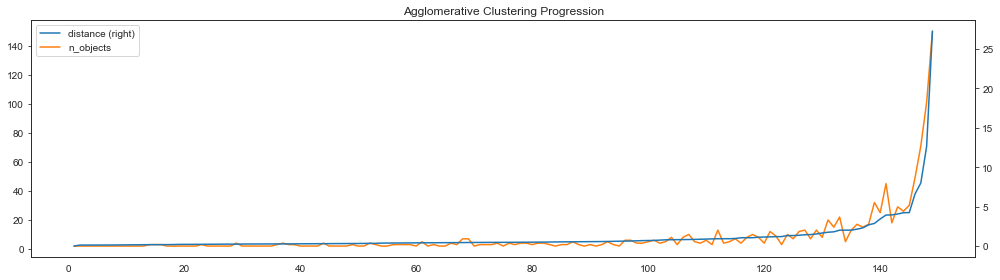

In [13]:
linkage_matrix[['distance', 'n_objects']].plot(secondary_y=['distance'],
                                               title='Agglomerative Clustering Progression',
                                               figsize=(14, 4))
plt.tight_layout();

### Compare linkage types

Hierarchical clustering provides insight into degrees of similarity among observations as it continues to merge data. A significant change in the similarity metric from one merge to the next suggests a natural clustering existed prior to this point. 
The dendrogram visualizes the successive merges as a binary tree, displaying the individual data points as leaves and the final merge as the root of the tree. It also shows how the similarity monotonically decreases from bottom to top. Hence, it is natural to select a clustering by cutting the dendrogram. 

The following figure illustrates the dendrogram for the classic Iris dataset with four classes and three features using the four different distance metrics introduced above. It evaluates the fit of the hierarchical clustering using the cophenetic correlation coefficient that compares the pairwise distances among points and the cluster similarity metric at which a pairwise merge occurred. A coefficient of 1 implies that closer points always merge earlier.

In [14]:
methods = ['single', 'complete', 'average', 'ward']
pairwise_distance = pdist(features_standardized)

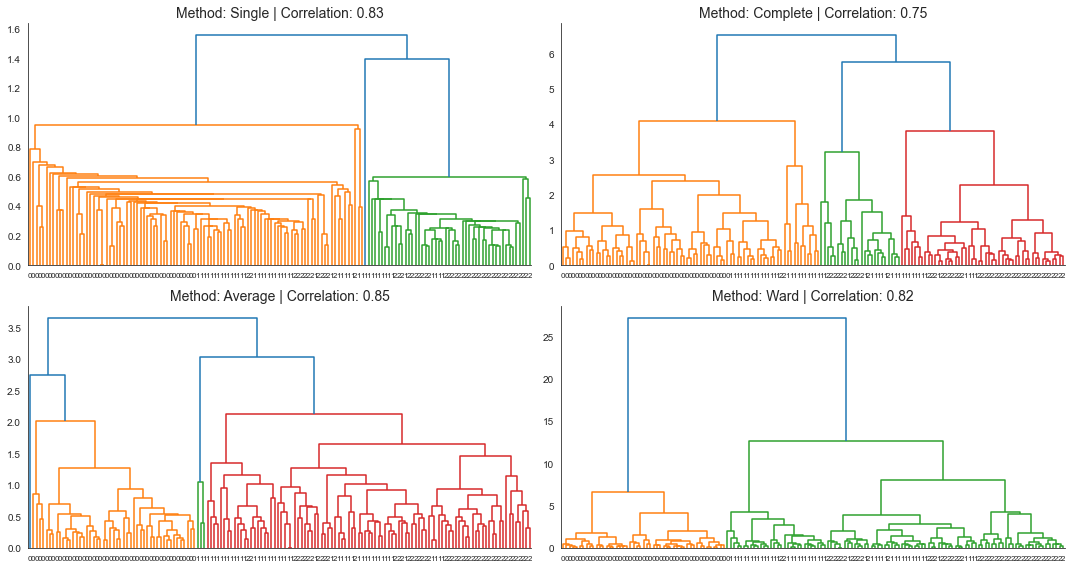

In [15]:
fig, axes = plt.subplots(figsize=(15, 8), nrows=2, ncols=2, sharex=True)
axes = axes.flatten()
for i, method in enumerate(methods):
    Z = linkage(features_standardized, method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z,
               labels=data.label.values,
               orientation='top',
               leaf_rotation=0.,
               leaf_font_size=8.,
               ax=axes[i])
    axes[i].set_title(f'Method: {method.capitalize()} | Correlation: {c:.2f}',
                      fontsize=14)


sns.despine()
fig.tight_layout()

Different linkage methods produce different dendrogram ‘looks’ so that we can not use this visualization to compare results across methods. In addition, the Ward method that minimizes the within-cluster variance may not properly reflect the change in variance but the total variance that may be misleading. Instead, other quality metrics like the cophenetic correlation or measures like inertia if aligned with the overall goal are more appropriate. 

### Get Cluster Members

In [16]:
n = len(Z)
from collections import OrderedDict
clusters = OrderedDict()

for i, row in enumerate(Z, 1):
    cluster = []
    for c in row[:2]:
        if c <= n:
            cluster.append(int(c))
        else:
            cluster += clusters[int(c)]
    clusters[n+i] = cluster

In [17]:
clusters[230]

[144, 124, 120, 143]

### Animate Agglomerative Clustering

In [18]:
def get_2D_coordinates():
    points = pd.DataFrame(features_2D).assign(n=1)
    return dict(enumerate(points.values.tolist()))

In [19]:
n_clusters = Z.shape[0]
points = get_2D_coordinates()
cluster_states = {0: get_2D_coordinates()}

for i, cluster in enumerate(Z[:, :2], 1):
    cluster_state = dict(cluster_states[i-1])
    merged_points = np.array([cluster_state.pop(c) for c in cluster])
    cluster_size = merged_points[:, 2]
    new_point = np.average(merged_points[:, :2],
                           axis=0,
                           weights=cluster_size).tolist()
    new_point.append(cluster_size.sum())
    cluster_state[n_clusters+i] = new_point
    cluster_states[i] = cluster_state

In [20]:
cluster_states[100]

{15: [-2.262214531601021, 2.6862844851105914, 1.0],
 41: [-1.8581224563735723, -2.3374151575533477, 1.0],
 60: [-0.11019628000062966, -2.654072818536564, 1.0],
 62: [0.5621083064431784, -1.7647243806169446, 1.0],
 106: [0.36701768786072503, -1.5615028914765063, 1.0],
 108: [2.0066864676766065, -0.7114386535471586, 1.0],
 109: [2.259777349012502, 1.9210103764598863, 1.0],
 114: [1.4676452010173249, -0.44227158737708283, 1.0],
 176: [0.28711522075373164, -0.24204262329732357, 2.0],
 179: [-2.2058211672986987, -0.09844552008358023, 2.0],
 185: [0.9688104990917802, 0.019079153840815277, 3.0],
 194: [0.7389335833626246, 0.6838170188840103, 2.0],
 197: [2.3691965862739517, 0.3396750063935282, 2.0],
 198: [-2.4657912495858003, -0.9936714816693257, 3.0],
 205: [1.9290326043911599, 0.5634757376107676, 3.0],
 206: [-1.9303546578376, 0.49803629560760027, 3.0],
 208: [-2.3324410024278306, 0.10599232941089083, 3.0],
 209: [2.365628354573734, 2.5914923595139348, 2.0],
 210: [-2.3753778947842483, -0.

### Set up Animation

In [21]:
%%capture
fig, ax = plt.subplots(figsize=(14, 6))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

sns.despine()
xmin, ymin = np.min(features_2D, axis=0) * 1.1
xmax, ymax = np.max(features_2D, axis=0) * 1.1
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

In [22]:
scat = ax.scatter([], [])


def animate(i):
    df = pd.DataFrame(cluster_states[i]).values.T
    scat.set_offsets(df[:, :2])
    scat.set_sizes((df[:, 2] * 2) ** 2)
    return scat,


anim = FuncAnimation(fig,
                     animate,
                     frames=cluster_states.keys(),
                     interval=20,
                     blit=False)

HTML(anim.to_html5_video())

### Scikit-Learn implementation

In [23]:
clusterer = AgglomerativeClustering(n_clusters=3)
data['clusters'] = clusterer.fit_predict(features_standardized)

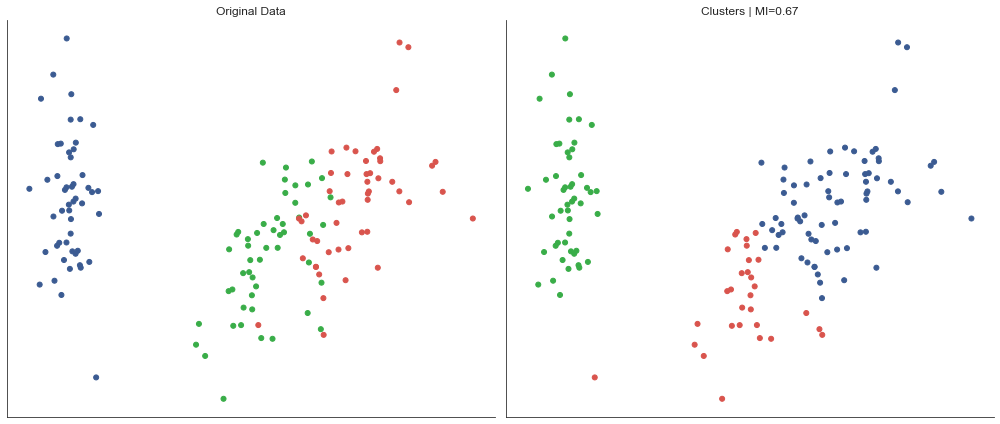

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)

axes[0].scatter(*features_2D.T, 
                c=data.label, 
                s=25, 
                cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, 
                c=data.clusters, 
                s=25, 
                cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))
for i in [0, 1]:
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)

sns.despine()
fig.tight_layout()

### Comparing Mutual Information for different Linkage Options

In [25]:
mutual_info = {}
for linkage_method in ['ward', 'complete', 'average']: 
    clusterer = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    clusters = clusterer.fit_predict(features_standardized)  
    mutual_info[linkage_method] = adjusted_mutual_info_score(clusters, labels)

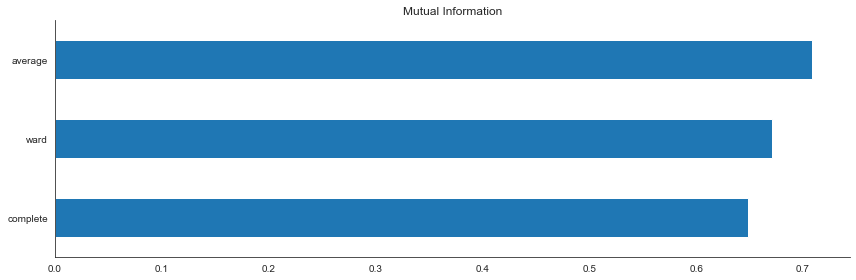

In [26]:
ax = (pd.Series(mutual_info)
      .sort_values()
      .plot.barh(figsize=(12, 4),
                 title='Mutual Information'))
sns.despine()
plt.tight_layout()

## Strengths and Weaknesses

The strengths of hierarchical clustering include that 
- you do not need to specify the number of clusters but instead offers insight about potential clustering by means of an intuitive visualization. 
- It produces a hierarchy of clusters that can serve as a taxonomy. 
- It can be combined with k-means to reduce the number of items at the start of the agglomerative process.

The weaknesses include 
- the high cost in terms of computation and memory because of the numerous similarity matrix updates.
- Another downside is that all merges are final so that it does not achieve the global optimum. - 
- Furthermore, the curse of dimensionality leads to difficulties with noisy, high-dimensional data.